In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from itertools import combinations
from scipy import stats
import random

In [2]:
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn import preprocessing 

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
train_df = pd.read_csv("train_ctrUa4K.csv")
#check the info of the dataset
print(train_df.shape)
train_df['Dependents'] = train_df['Dependents'].replace(['3+'],'3')
train_df['Married']=train_df['Married'].fillna('No')
train_df.info()
print('-'*30)
# resource_data = pd.read_csv("/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/resources.csv")
# #check the info of the dataset
# resource_data .info()

(614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
------------------------------


In [5]:
train_df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [6]:
test_df= pd.read_csv("test_lAUu6dG.csv")
test_df['Dependents'] = test_df['Dependents'].replace(['3+'],'3')
test_df['Loan_Amount_Term'] = test_df['Loan_Amount_Term'].replace([6.0],12.0)
test_df['Loan_Amount_Term'] = test_df['Loan_Amount_Term'].replace([350.0],360.0)
#check the info of the dataset
print(test_df.shape)
# test_df.fillna(-1,inplace=True)
test_df.info()

(367, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


# Find all the null indecies and columns

In [7]:
nan_=['Self_Employed','Credit_History','Loan_Amount_Term','Gender','Dependents','LoanAmount']

def indecies(df,l):
    nan_col_indecies=[];nan_indecies=[]
    for i in nan_:
        s=df[df[i].isnull()].index.tolist()
        nan_col_indecies.append(s)
        nan_indecies.extend(s)
    return nan_col_indecies,nan_indecies

In [8]:
nan_col_indecies_tr,nan_indecies_tr = indecies(train_df,nan_)
nan_col_indecies_te,nan_indecies_te = indecies(test_df,nan_)

In [9]:
sample_df=pd.read_csv('sample_submission_49d68Cx.csv')
sample_df.head(10)

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N
5,LP001054,N
6,LP001055,N
7,LP001056,N
8,LP001059,N
9,LP001067,N


In [10]:
num_columns=['ApplicantIncome','CoapplicantIncome','LoanAmount']
cat_columns=['Gender','Married','Dependents','Education','Self_Employed','Loan_Amount_Term','Credit_History','Property_Area',]#'Loan_Status']

In [11]:
le=LabelEncoder()
train_df[cat_columns] = train_df[cat_columns].apply(le.fit_transform)
test_df[cat_columns] = test_df[cat_columns].apply(le.fit_transform)

output_labels=LabelEncoder()
train_df['Loan_Status']=output_labels.fit_transform(train_df['Loan_Status'])

# Model based imputation

In [12]:
t1=train_df.copy()
t2=test_df.copy()
t1.shape,t2.shape

#remove all rows that have null alues
t1.drop(set(nan_indecies_tr),axis=0,inplace=True)
t2.drop(set(nan_indecies_te),axis=0,inplace=True)
t_tr=pd.concat([t1,t2])
t_tr.shape

(769, 13)

In [13]:
#build the model and impute each mssing value
col_1=['Married','Education','ApplicantIncome','CoapplicantIncome','Property_Area']
trp=[];tep=[]
for i in range(len(nan_)):
    X=t_tr[col_1]
    y=t_tr[nan_[i]]
    model_= CatBoostClassifier()
    model_.fit(X,y)
    p1=[];p2=[]
    for j in range(len(nan_col_indecies_tr[i])):
        p=model_.predict(train_df[X.columns][nan_col_indecies_tr[i][j]:nan_col_indecies_tr[i][j]+1])
        train_df[nan_[i]][nan_col_indecies_tr[i][j]:nan_col_indecies_tr[i][j]+1]=p[0]
        p1.append(p)
    trp.append(p1)
    for j in range(len(nan_col_indecies_te[i])):
        p=model_.predict(test_df[X.columns][nan_col_indecies_te[i][j]:nan_col_indecies_te[i][j]+1])
        test_df[nan_[i]][nan_col_indecies_te[i][j]:nan_col_indecies_te[i][j]+1]=p[0]
        p2.append(p)
    tep.append(p2)
    col_1.append(str(nan_[i]))
    print('-'*10)

Learning rate set to 0.009209
0:	learn: 0.6851324	total: 58.1ms	remaining: 58s
1:	learn: 0.6770957	total: 60.5ms	remaining: 30.2s
2:	learn: 0.6706298	total: 62.7ms	remaining: 20.8s
3:	learn: 0.6628949	total: 65.3ms	remaining: 16.3s
4:	learn: 0.6568245	total: 66.6ms	remaining: 13.2s
5:	learn: 0.6490271	total: 68.7ms	remaining: 11.4s
6:	learn: 0.6414507	total: 71.6ms	remaining: 10.2s
7:	learn: 0.6356315	total: 74.4ms	remaining: 9.22s
8:	learn: 0.6298564	total: 76.5ms	remaining: 8.42s
9:	learn: 0.6231425	total: 78.9ms	remaining: 7.81s
10:	learn: 0.6172293	total: 80.8ms	remaining: 7.27s
11:	learn: 0.6110048	total: 82.3ms	remaining: 6.78s
12:	learn: 0.6060124	total: 83.5ms	remaining: 6.34s
13:	learn: 0.6000625	total: 85.6ms	remaining: 6.03s
14:	learn: 0.5952408	total: 86.8ms	remaining: 5.7s
15:	learn: 0.5898824	total: 89.1ms	remaining: 5.48s
16:	learn: 0.5838610	total: 91.5ms	remaining: 5.29s
17:	learn: 0.5779895	total: 93.8ms	remaining: 5.12s
18:	learn: 0.5736023	total: 95.4ms	remaining: 4

In [14]:
#to find similar values for missing values
def similar_(k,col):
    d_tr=train_df[col].value_counts()
    d_te=test_df[col].value_counts()
    keys=[];tr_values=[]
    for i in d_te.keys():
        if d_te[i]==d_te[k]:
            if i not in missing:
                    keys.append(i)
                    tr_values.append(d_tr[i])
    return keys,tr_values,d_tr,d_te

In [15]:
#replace missing values with similar alue
def replace(missing,col): 
    keys=[]
    for i in missing:
        k,v,d_tr,d_te=similar_(i,col)
        s_keys=[]
        for i in k:
            if d_tr[i]==stats.mode(v)[0][0]:
                s_keys.append(i)
        if len(s_keys)==0:
            min=10;u_key=0
            for i in d_te.keys():
                if d_te[i]<=min and i not in missing:
                    min=d_te[i]
                    u_key=i
            keys.append(u_key)
        else:
            keys.append(random.choice(s_keys))
    return keys

In [16]:
comb=combinations(cat_columns,2)

combined_cols2=[]
for i in comb:
    train_df[i[0]+'_'+i[1]]= train_df[i[0]].astype(str)+'_'+train_df[i[1]].astype(str)
    test_df[i[0]+'_'+i[1]]= test_df[i[0]].astype(str)+'_'+test_df[i[1]].astype(str)
    combined_cols2.append(i[0]+'_'+i[1])

In [17]:
#replace those missing values
for i in train_df.keys()[13:41]:
    missing=[]
    l1=train_df[i].value_counts().keys();l2=test_df[i].value_counts().keys()
    if len(l1)!=len(l2) or not(np.all(l1==l2)):
        for v in l2:
            if v not in(l1):
                missing.append(v)
        if len(missing)!=0:
            keys=replace(missing,i)
            for r in range(len(missing)):
                test_df[i] = test_df[i].replace(missing[r],keys[r])

# Frequency Encoding

In [18]:
def frequency_encoding(column_name,output_column_name,df1,df2):
    fe_pol = (df1.groupby(column_name).size()) / len(df1)
    df2[output_column_name] = df2[column_name].apply(lambda x : fe_pol[x])

In [19]:
for i in cat_columns:
    frequency_encoding(i,i+'_Ren',train_df,train_df)
    frequency_encoding(i,i+'_Ren',train_df,test_df)
    print(i)

Gender
Married
Dependents
Education
Self_Employed
Loan_Amount_Term
Credit_History
Property_Area


In [20]:
for i in combined_cols2:
    print(i)
    frequency_encoding(i,i+'_Ren',train_df,train_df)
    frequency_encoding(i,i+'_Ren',train_df,test_df)

Gender_Married
Gender_Dependents
Gender_Education
Gender_Self_Employed
Gender_Loan_Amount_Term
Gender_Credit_History
Gender_Property_Area
Married_Dependents
Married_Education
Married_Self_Employed
Married_Loan_Amount_Term
Married_Credit_History
Married_Property_Area
Dependents_Education
Dependents_Self_Employed
Dependents_Loan_Amount_Term
Dependents_Credit_History
Dependents_Property_Area
Education_Self_Employed
Education_Loan_Amount_Term
Education_Credit_History
Education_Property_Area
Self_Employed_Loan_Amount_Term
Self_Employed_Credit_History
Self_Employed_Property_Area
Loan_Amount_Term_Credit_History
Loan_Amount_Term_Property_Area
Credit_History_Property_Area


# Min max Scaling

In [21]:
for i in num_columns:
    min_=min(train_df[i])
    max_=max(train_df[i]) 
    diff=max_-min_
    train_df[i+'_min_max_scaled']=(train_df[i]-min_)/diff
    test_df[i+'_min_max_scaled']=(test_df[i]-min_)/diff

In [22]:
y=train_df['Loan_Status']
X=train_df.drop(['Loan_ID','Loan_Status'],axis=1)
X_test=test_df.drop(['Loan_ID'],axis=1)

In [23]:
for i in cat_columns:
    X=X.drop([i],axis=1)
    X_test=X_test.drop([i],axis=1)
for i in num_columns:
    X=X.drop([i],axis=1)
    X_test=X_test.drop([i],axis=1)
for i in combined_cols2:
    X=X.drop([i],axis=1)
    X_test=X_test.drop([i],axis=1)

In [24]:
X.head(10)

,Gender_Ren,Married_Ren,Dependents_Ren,Education_Ren,Self_Employed_Ren,Loan_Amount_Term_Ren,Credit_History_Ren,Property_Area_Ren,Gender_Married_Ren,Gender_Dependents_Ren,...,Education_Property_Area_Ren,Self_Employed_Loan_Amount_Term_Ren,Self_Employed_Credit_History_Ren,Self_Employed_Property_Area_Ren,Loan_Amount_Term_Credit_History_Ren,Loan_Amount_Term_Property_Area_Ren,Credit_History_Property_Area_Ren,ApplicantIncome_min_max_scaled,CoapplicantIncome_min_max_scaled,LoanAmount_min_max_scaled
0,0.814332,0.351792,0.581433,0.781759,0.86645,0.85342,0.851792,0.328990,0.216612,0.442997,...,0.263844,0.741042,0.737785,0.289902,0.736156,0.263844,0.278502,0.070489,0.000000,0.191027
1,0.814332,0.648208,0.166124,0.781759,0.86645,0.85342,0.851792,0.291531,0.597720,0.135179,...,0.213355,0.741042,0.737785,0.249186,0.736156,0.258958,0.242671,0.054830,0.036192,0.172214
2,0.814332,0.648208,0.581433,0.781759,0.13355,0.85342,0.851792,0.328990,0.597720,0.442997,...,0.263844,0.112378,0.114007,0.039088,0.736156,0.263844,0.278502,0.035250,0.000000,0.082489
3,0.814332,0.648208,0.581433,0.218241,0.86645,0.85342,0.851792,0.328990,0.597720,0.442997,...,0.065147,0.741042,0.737785,0.289902,0.736156,0.263844,0.278502,0.030093,0.056592,0.160637
4,0.814332,0.351792,0.581433,0.781759,0.86645,0.85342,0.851792,0.328990,0.216612,0.442997,...,0.263844,0.741042,0.737785,0.289902,0.736156,0.263844,0.278502,0.072356,0.000000,0.191027
5,0.814332,0.648208,0.167752,0.781759,0.13355,0.85342,0.851792,0.328990,0.597720,0.156352,...,0.263844,0.112378,0.114007,0.039088,0.736156,0.263844,0.278502,0.065145,0.100703,0.373372
6,0.814332,0.648208,0.581433,0.218241,0.86645,0.85342,0.851792,0.328990,0.597720,0.442997,...,0.065147,0.741042,0.737785,0.289902,0.736156,0.263844,0.278502,0.027001,0.036384,0.124457
7,0.814332,0.648208,0.084691,0.781759,0.86645,0.85342,0.148208,0.379479,0.597720,0.079805,...,0.304560,0.741042,0.128664,0.327362,0.117264,0.330619,0.048860,0.035696,0.060096,0.215630
8,0.814332,0.648208,0.167752,0.781759,0.86645,0.85342,0.851792,0.328990,0.597720,0.156352,...,0.263844,0.741042,0.737785,0.289902,0.736156,0.263844,0.278502,0.047693,0.036624,0.230101
9,0.814332,0.648208,0.166124,0.781759,0.86645,0.85342,0.851792,0.379479,0.597720,0.135179,...,0.304560,0.741042,0.737785,0.327362,0.736156,0.330619,0.330619,0.156970,0.263230,0.492041


In [25]:
print(train_df.shape)
print(X.shape,y.shape)
print(X_test.shape)

(614, 80)
(614, 39) (614,)
(367, 39)


# Model

In [26]:
model=CatBoostClassifier(iterations=1000,learning_rate=0.01,depth=2,l2_leaf_reg=20,silent=True)
model.fit(X,y)

In [27]:
accuracy_score(y,model.predict(X))

0.8159609120521173

# Important features

In [29]:
f_importance_df = pd.DataFrame(model.get_feature_importance(), columns=['importance'], index=X.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

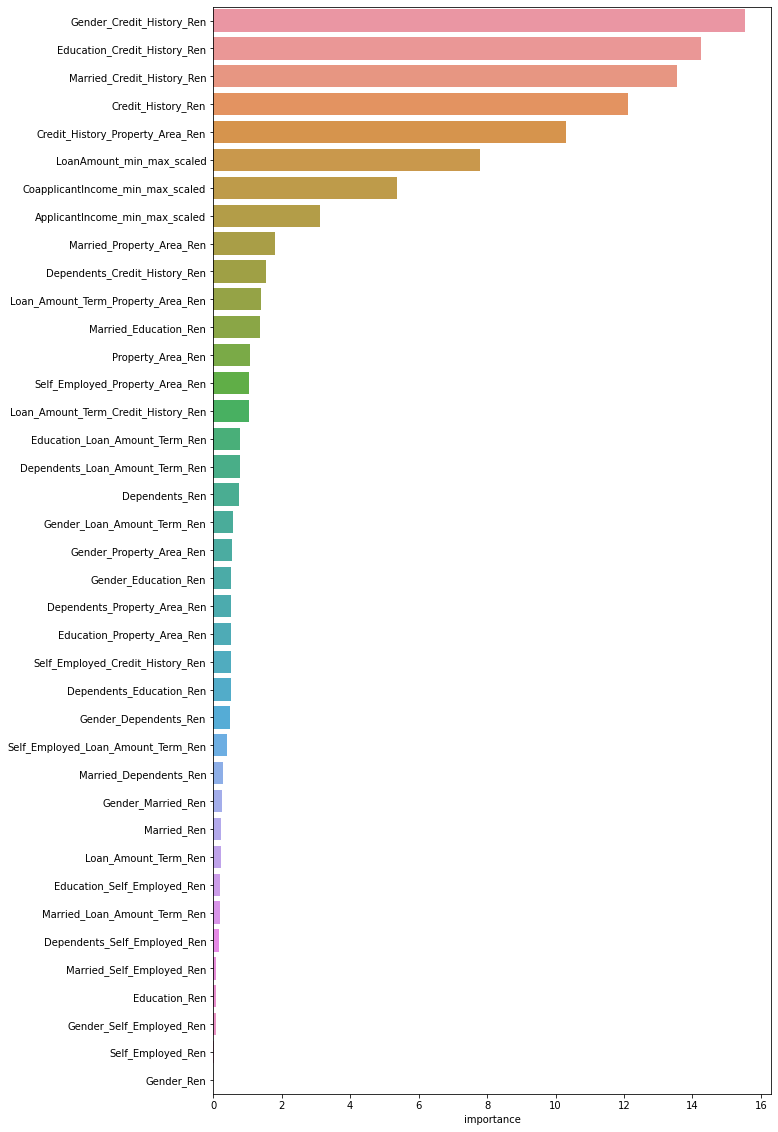

In [30]:
plt.figure(figsize=(10,20))
sns.barplot(x=f_importance_df.importance[:500], y=f_importance_df.index[:500]);

In [31]:
p=model.predict(X_test)

In [32]:
def predict(p):
    predictions=[]
    for i in p:
        if i==0:
            predictions.append('N')
        else:
            predictions.append('Y')
    return predictions

In [34]:
sample_df['Loan_Status']=predict(model.predict(X_test))
sample_df.to_csv('submission_final.csv',index=False)

In [35]:
s1=pd.read_csv('submission_final.csv')
s1.head(10)

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
5,LP001054,Y
6,LP001055,Y
7,LP001056,N
8,LP001059,Y
9,LP001067,Y


In [36]:
from sklearn.model_selection import KFold
kfold=KFold(10,True,1)

In [38]:
f_t1=[];f_c1=[]
for train, cv in kfold.split(X):
    model.fit(X.iloc[train],y.iloc[train]) 
    
    pt=model.predict(X.iloc[train])
    pc=model.predict(X.iloc[cv])
 
    fa=accuracy_score(y.iloc[train],pt)
    fc=accuracy_score(y.iloc[cv],pc)

    print(fa,fc)
    f_t1.append(fa)
    f_c1.append(fc)

0.8242753623188406 0.7419354838709677
0.8079710144927537 0.8548387096774194
0.822463768115942 0.7419354838709677
0.8152173913043478 0.7741935483870968
0.8047016274864376 0.8852459016393442
0.810126582278481 0.8688524590163934
0.8209764918625678 0.7704918032786885
0.810126582278481 0.8524590163934426
0.8227848101265823 0.7540983606557377
0.8083182640144665 0.8524590163934426


In [40]:
print('K fold train score : ',np.mean(f_t1))
print('K fold cv score : ',np.mean(f_c1))

K fold train score :  0.8146961894278899
K fold cv score :  0.80965097831835
